<a href="https://colab.research.google.com/github/Bix4UMD/BIOI611_lab/blob/main/docs/BIOI611_DESeq2_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis of RNA-seq data using R

## Instsall required R packages


In [ ]:
if (!require("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

BiocManager::install("DESeq2")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com

Bioconductor version 3.19 (BiocManager 1.30.25), R 4.4.1 (2024-06-14)

Installing package(s) 'BiocVersion', 'DESeq2'

also installing the dependencies ‘formatR’, ‘UCSC.utils’, ‘GenomeInfoDbData’, ‘zlibbioc’, ‘abind’, ‘SparseArray’, ‘lambda.r’, ‘futile.options’, ‘GenomeInfoDb’, ‘XVector’, ‘S4Arrays’, ‘DelayedArray’, ‘futile.logger’, ‘snow’, ‘BH’, ‘S4Vectors’, ‘IRanges’, ‘GenomicRanges’, ‘SummarizedExperiment’, ‘BiocGenerics’, ‘Biobase’, ‘BiocParallel’, ‘matrixStats’, ‘locfit’, ‘MatrixGenerics’, ‘RcppArmadillo’


Old packages: 'broom', 'httr2'



## Load R packages

In [ ]:
library(DESeq2)
library(dplyr)

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, table,
    tapply, union, unique, unsplit, which.max, which.min



Attaching package: ‘S4Vectors’


The following object is masked from ‘package:utils’:

    findMatches


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package: IRanges

Loading required package: GenomicRanges

Loading required package: GenomeInfoDb

Loading r

## Navigation in the file system and read the count files


In [ ]:
getwd()

[1] "/content"

In [ ]:
list.files()

[1] "N2_day1_rep1.ReadsPerGene.out.tab" "N2_day1_rep2.ReadsPerGene.out.tab"
[3] "N2_day1_rep3.ReadsPerGene.out.tab" "N2_day7_rep1.ReadsPerGene.out.tab"
[5] "N2_day7_rep2.ReadsPerGene.out.tab" "N2_day7_rep3.ReadsPerGene.out.tab"
[7] "sample_data"

In [ ]:
file_paths <- list.files(pattern = "*..ReadsPerGene.out.tab")
file_paths

[1] "N2_day1_rep1.ReadsPerGene.out.tab" "N2_day1_rep2.ReadsPerGene.out.tab"
[3] "N2_day1_rep3.ReadsPerGene.out.tab" "N2_day7_rep1.ReadsPerGene.out.tab"
[5] "N2_day7_rep2.ReadsPerGene.out.tab" "N2_day7_rep3.ReadsPerGene.out.tab"

In [ ]:
# Function to read the STAR ReadsPerGene.out.tab file
read_star_file <- function(file_path) {
  # Read the file
  df <- read.table(file_path, header = FALSE, stringsAsFactors = FALSE)

  # Keep only the first (gene) and second (unstranded counts) columns
  df <- df %>% select(V1, V2)

  # Rename the columns for clarity (GeneID and counts for this sample)
  colnames(df) <- c("GeneID", gsub(".ReadsPerGene.out.tab", "", basename(file_path)))

  return(df)
}

# Read all files into a list of data frames
list_of_dfs <- lapply(file_paths, read_star_file)

# Merge all data frames by the GeneID column
merged_df <- Reduce(function(x, y) merge(x, y, by = "GeneID"), list_of_dfs)

merged_df <- merged_df[-c(1:4), ]

# Check the first few rows of the combined data frame
head(merged_df)

# Optionally, write the combined data frame to a CSV file
write.csv(merged_df, "combined_gene_counts.csv", row.names = FALSE)

,GeneID,N2_day1_rep1,N2_day1_rep2,N2_day1_rep3,N2_day7_rep1,N2_day7_rep2,N2_day7_rep3
,<chr>,<int>,<int>,<int>,<int>,<int>,<int>
5,WBGene00000001,3227,2168,2589,5659,2619,5239
6,WBGene00000002,270,203,266,355,191,425
7,WBGene00000003,341,415,411,387,255,499
8,WBGene00000004,584,438,518,1028,541,888
9,WBGene00000005,383,395,483,119,65,189
10,WBGene00000006,343,344,334,206,114,220


In [ ]:
rownames(merged_df) = merged_df$GeneID
merged_df$GeneID = NULL

## Check count matrix

Different samples have different total number of counts


In [ ]:
as.data.frame(colSums(merged_df))

,colSums(merged_df)
,<dbl>
N2_day1_rep1,37398898
N2_day1_rep2,29488709
N2_day1_rep3,34593136
N2_day7_rep1,48275683
N2_day7_rep2,23204449
N2_day7_rep3,46005617


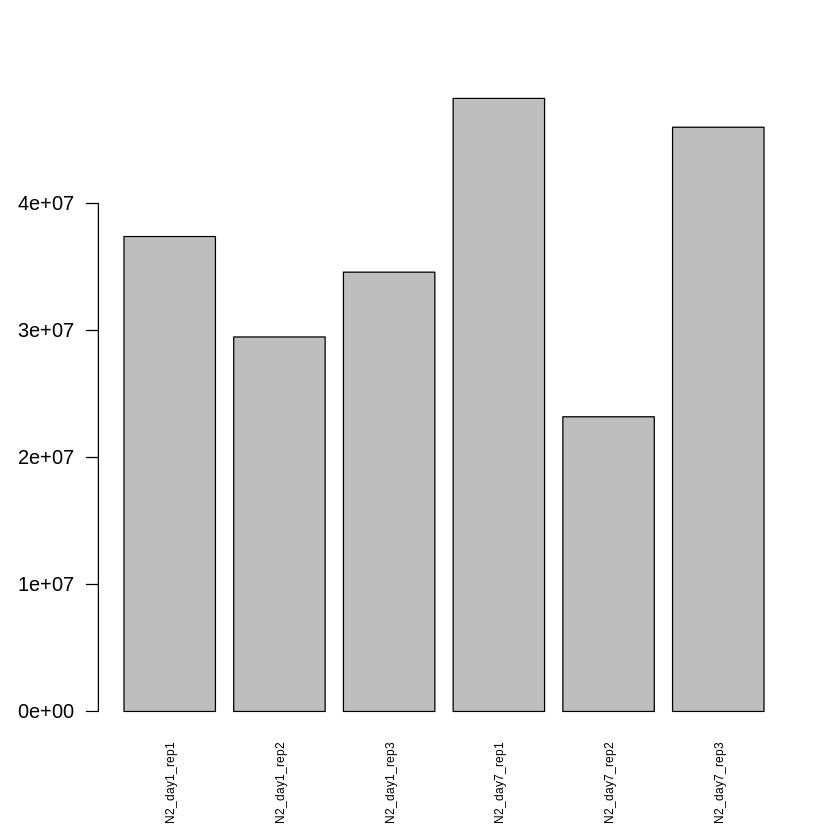

In [ ]:
barplot(colSums(merged_df),
         las = 2,
         cex.names= 0.6)

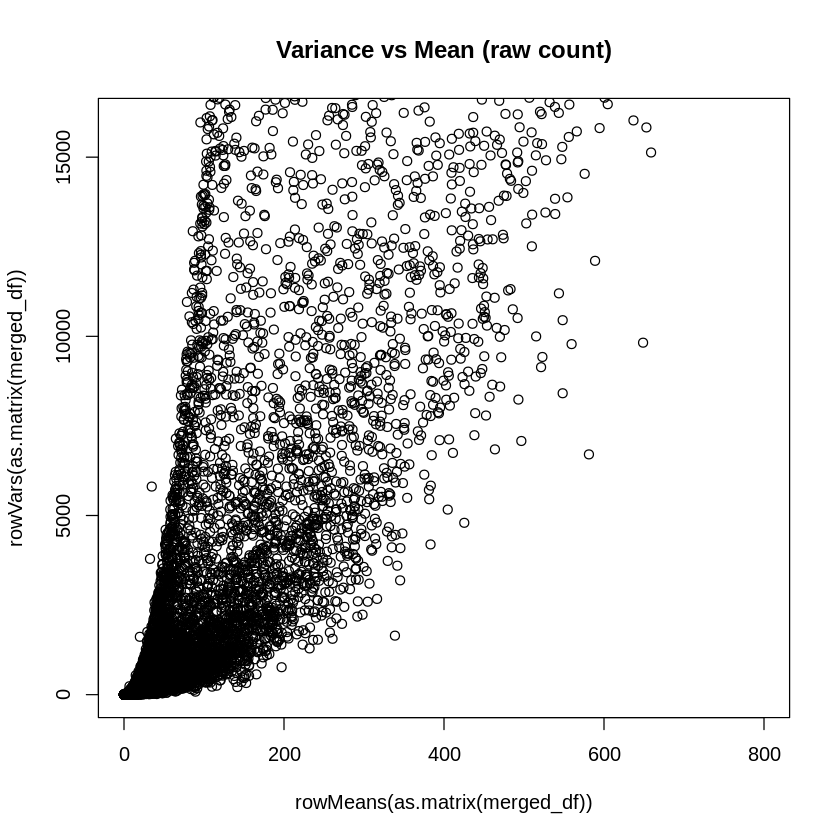

In [ ]:
# Raw counts mean expression Vs standard Deviation (SD)
plot(rowMeans(as.matrix(merged_df)),
     rowVars(as.matrix(merged_df)),
     main = 'Variance vs Mean (raw count)',
     xlim = c(0,800),
     ylim = c(0,16000))

In [ ]:
coldata <- colnames(merged_df)
coldata_df <- cbind(group = gsub("_rep\\d", "", coldata))
rownames(coldata_df) = coldata
coldata_df

,group
N2_day1_rep1,N2_day1
N2_day1_rep2,N2_day1
N2_day1_rep3,N2_day1
N2_day7_rep1,N2_day7
N2_day7_rep2,N2_day7
N2_day7_rep3,N2_day7


## Understand normalized count in DESeq2





####  Create a pseudo-reference sample (row-wise mean after log transformation)

In [ ]:
log_data = log(merged_df)
head(log_data)

,N2_day1_rep1,N2_day1_rep2,N2_day1_rep3,N2_day7_rep1,N2_day7_rep2,N2_day7_rep3
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
WBGene00000001,8.079308,7.681560,7.859027,8.641002,7.870548,8.563886
WBGene00000002,5.598422,5.313206,5.583496,5.872118,5.252273,6.052089
WBGene00000003,5.831882,6.028279,6.018593,5.958425,5.541264,6.212606
WBGene00000004,6.369901,6.082219,6.249975,6.935370,6.293419,6.788972
WBGene00000005,5.948035,5.978886,6.180017,4.779123,4.174387,5.241747
WBGene00000006,5.837730,5.840642,5.811141,5.327876,4.736198,5.393628


 The code below creates a new column called `pseudo_reference` that contains the average log-transformed expression value for each gene across all samples. This pseudo-reference is similar to calculating a "reference sample" to compare other samples.

In [ ]:
library(dplyr)
library(tibble) # rownames_to_column

log_data = log_data %>%
             rownames_to_column('gene') %>%
             mutate (pseudo_reference = rowMeans(log_data))

head(log_data)

,gene,N2_day1_rep1,N2_day1_rep2,N2_day1_rep3,N2_day7_rep1,N2_day7_rep2,N2_day7_rep3,pseudo_reference
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,WBGene00000001,8.079308,7.681560,7.859027,8.641002,7.870548,8.563886,8.115889
2,WBGene00000002,5.598422,5.313206,5.583496,5.872118,5.252273,6.052089,5.611934
3,WBGene00000003,5.831882,6.028279,6.018593,5.958425,5.541264,6.212606,5.931841
4,WBGene00000004,6.369901,6.082219,6.249975,6.935370,6.293419,6.788972,6.453309
5,WBGene00000005,5.948035,5.978886,6.180017,4.779123,4.174387,5.241747,5.383699
6,WBGene00000006,5.837730,5.840642,5.811141,5.327876,4.736198,5.393628,5.491203


In [ ]:
filtered_log_data = log_data %>% filter(pseudo_reference != "-Inf")
head(filtered_log_data)

,gene,N2_day1_rep1,N2_day1_rep2,N2_day1_rep3,N2_day7_rep1,N2_day7_rep2,N2_day7_rep3,pseudo_reference
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,WBGene00000001,8.079308,7.681560,7.859027,8.641002,7.870548,8.563886,8.115889
2,WBGene00000002,5.598422,5.313206,5.583496,5.872118,5.252273,6.052089,5.611934
3,WBGene00000003,5.831882,6.028279,6.018593,5.958425,5.541264,6.212606,5.931841
4,WBGene00000004,6.369901,6.082219,6.249975,6.935370,6.293419,6.788972,6.453309
5,WBGene00000005,5.948035,5.978886,6.180017,4.779123,4.174387,5.241747,5.383699
6,WBGene00000006,5.837730,5.840642,5.811141,5.327876,4.736198,5.393628,5.491203


### Calculate log-fold change between each sample and the pseudo-reference for each gene

The code below subtracts the pseudo-reference from each sample's expression values. This step calculates the log-fold change between each sample and the pseudo-reference for each gene.


In [ ]:
ratio_data = sweep(filtered_log_data[,2:7], 1, filtered_log_data[,8], "-")
head(ratio_data)

,N2_day1_rep1,N2_day1_rep2,N2_day1_rep3,N2_day7_rep1,N2_day7_rep2,N2_day7_rep3
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,-0.03658044,-0.4343283,-0.25686165,0.52511385,-0.2453408,0.4479973
2,-0.01351215,-0.2987281,-0.02843780,0.26018368,-0.3596607,0.4401551
3,-0.09995895,0.0964371,0.08675179,0.02658327,-0.3905779,0.2807647
4,-0.08340845,-0.3710905,-0.20333419,0.48206101,-0.1598902,0.3356623
5,0.56433579,0.5951866,0.79631746,-0.60457570,-1.2093119,-0.1419522
6,0.34652790,0.3494391,0.31993845,-0.16332637,-0.7550041,-0.0975750


The code below computes the median log-fold change for each sample across all genes.
The `2` indicates that the function is applied to columns, i.e., for each sample.

In [ ]:
sample_medians = apply(ratio_data, 2, median)
sample_medians

N2_day1_rep1 N2_day1_rep2 N2_day1_rep3 N2_day7_rep1 N2_day7_rep2 N2_day7_rep3 
 0.002358348 -0.209811795 -0.056801413  0.271475841 -0.334828228  0.354879741

Since the data was log-transformed earlier, this step reverses the log transformation by exponentiating the median log-fold changes to obtain the scaling factors.

In [ ]:
# scaling factor = e^median
scaling_factors = exp(sample_medians)
scaling_factors

N2_day1_rep1 N2_day1_rep2 N2_day1_rep3 N2_day7_rep1 N2_day7_rep2 N2_day7_rep3 
   1.0023611    0.8107368    0.9447817    1.3118992    0.7154610    1.4260092

This step below normalizes each sample by its scaling factors, making the data comparable across samples. The result is a normalized gene expression matrix.

### Normalize the counts

In [ ]:
manually_normalized = sweep(merged_df, 2, scaling_factors, "/")
head(manually_normalized)

,N2_day1_rep1,N2_day1_rep2,N2_day1_rep3,N2_day7_rep1,N2_day7_rep2,N2_day7_rep3
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
WBGene00000001,3219.3986,2674.1107,2740.3156,4313.59368,3660.57703,3673.8895
WBGene00000002,269.3640,250.3895,281.5465,270.60006,266.96075,298.0346
WBGene00000003,340.1968,511.8800,435.0211,294.99218,356.41357,349.9276
WBGene00000004,582.6243,540.2493,548.2748,783.59680,756.15585,622.7169
WBGene00000005,382.0978,487.2111,511.2292,90.70819,90.85052,132.5377
WBGene00000006,342.1920,424.3054,353.5208,157.02426,159.33783,154.2767


## Run DESeq2 to identify DEG

In [ ]:
dds <- DESeqDataSetFromMatrix(countData = merged_df,
                              colData = coldata_df,
                              design =~ group)

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”


NULL

In [ ]:
dds <- DESeq(dds)

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



In [ ]:
sizeFactors(dds)

N2_day1_rep1 N2_day1_rep2 N2_day1_rep3 N2_day7_rep1 N2_day7_rep2 N2_day7_rep3 
   1.0023611    0.8107368    0.9447817    1.3118992    0.7154610    1.4260092

In [ ]:
head(counts(dds,  normalized = TRUE))

,N2_day1_rep1,N2_day1_rep2,N2_day1_rep3,N2_day7_rep1,N2_day7_rep2,N2_day7_rep3
WBGene00000001,3219.3986,2674.1107,2740.3156,4313.59368,3660.57703,3673.8895
WBGene00000002,269.3640,250.3895,281.5465,270.60006,266.96075,298.0346
WBGene00000003,340.1968,511.8800,435.0211,294.99218,356.41357,349.9276
WBGene00000004,582.6243,540.2493,548.2748,783.59680,756.15585,622.7169
WBGene00000005,382.0978,487.2111,511.2292,90.70819,90.85052,132.5377
WBGene00000006,342.1920,424.3054,353.5208,157.02426,159.33783,154.2767


The function `plotDispEsts` shows the dispersion by mean of normalized counts. We expect the dispersion to decrease as the mean of normalized counts increases.


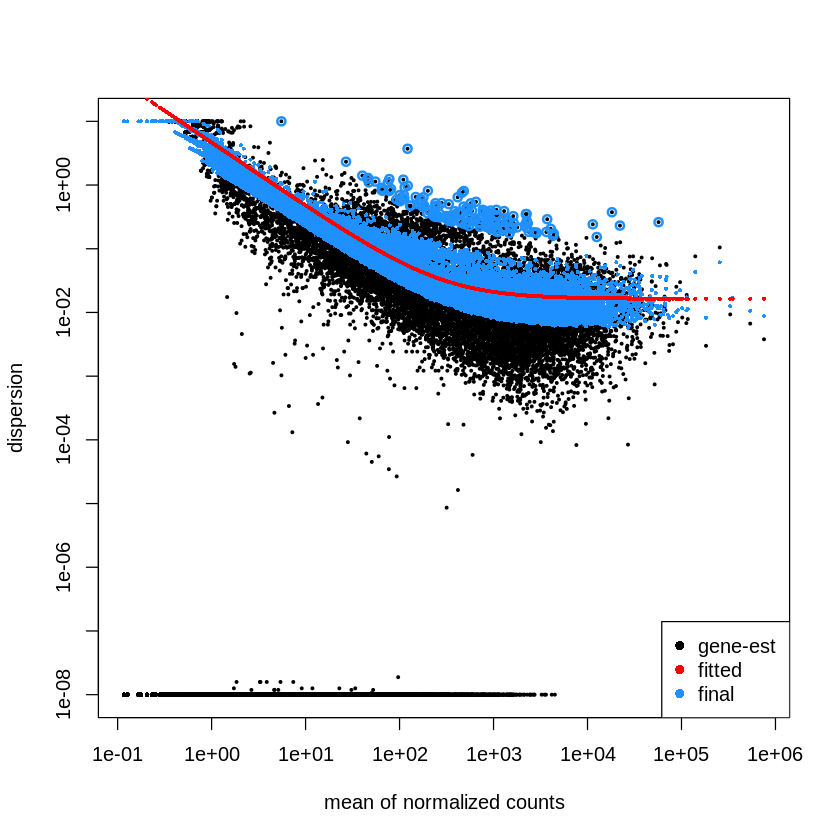

In [ ]:
plotDispEsts(dds)

In [ ]:
res <- results(dds)
res

log2 fold change (MLE): group N2 day7 vs N2 day1 
Wald test p-value: group N2 day7 vs N2 day1 
DataFrame with 46926 rows and 6 columns
                baseMean log2FoldChange     lfcSE      stat      pvalue
               <numeric>      <numeric> <numeric> <numeric>   <numeric>
WBGene00000001  3380.314      0.4320800  0.136502  3.165370 1.54886e-03
WBGene00000002   272.816      0.0620929  0.165747  0.374626 7.07939e-01
WBGene00000003   381.405     -0.3623262  0.199673 -1.814594 6.95864e-02
WBGene00000004   638.936      0.3698102  0.151232  2.445312 1.44727e-02
WBGene00000005   282.439     -2.1244976  0.227771 -9.327337 1.08564e-20
...                  ...            ...       ...       ...         ...
WBGene00306078  0.566369       0.947326  3.076775  0.307896 7.58162e-01
WBGene00306080  0.243919       1.429602  4.042905  0.353608 7.23633e-01
WBGene00306081 27.265033      -3.108820  0.627823 -4.951747 7.35501e-07
WBGene00306121 14.219195      -0.210100  0.691162 -0.303981 7.61142e-01
W

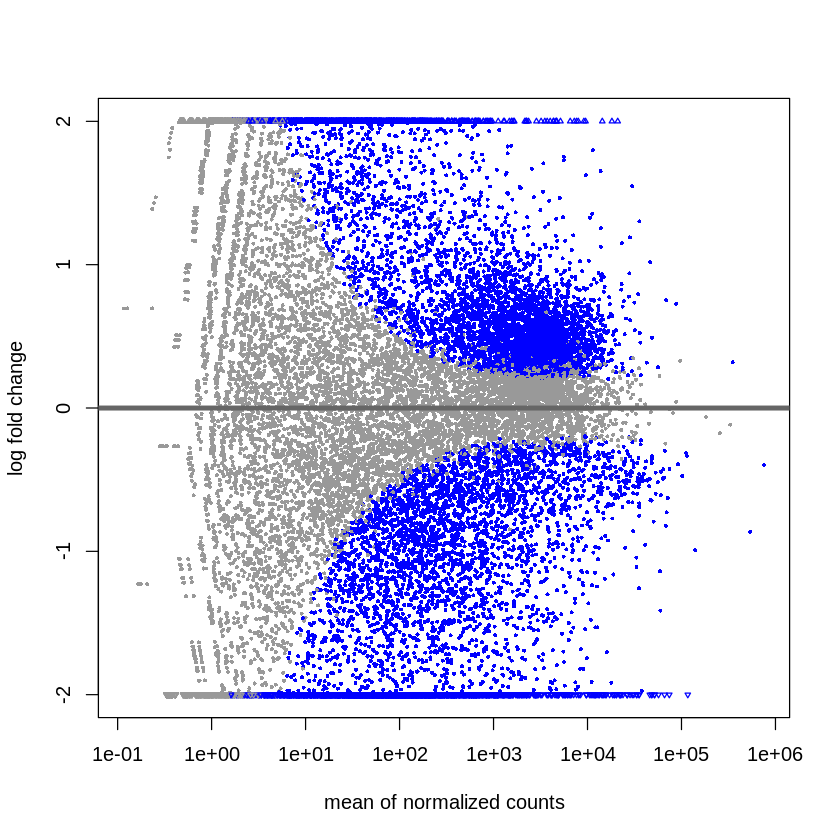

In [ ]:
plotMA(res, ylim=c(-2,2))

In [ ]:
write.csv(res, file = "BIOI_bulkRNAseq_SE_DESeq2_res.csv")

### Plot normalized genes

The function `plotCounts` is used to plot normalized counts plus a pseudocount of 0.5 by default.

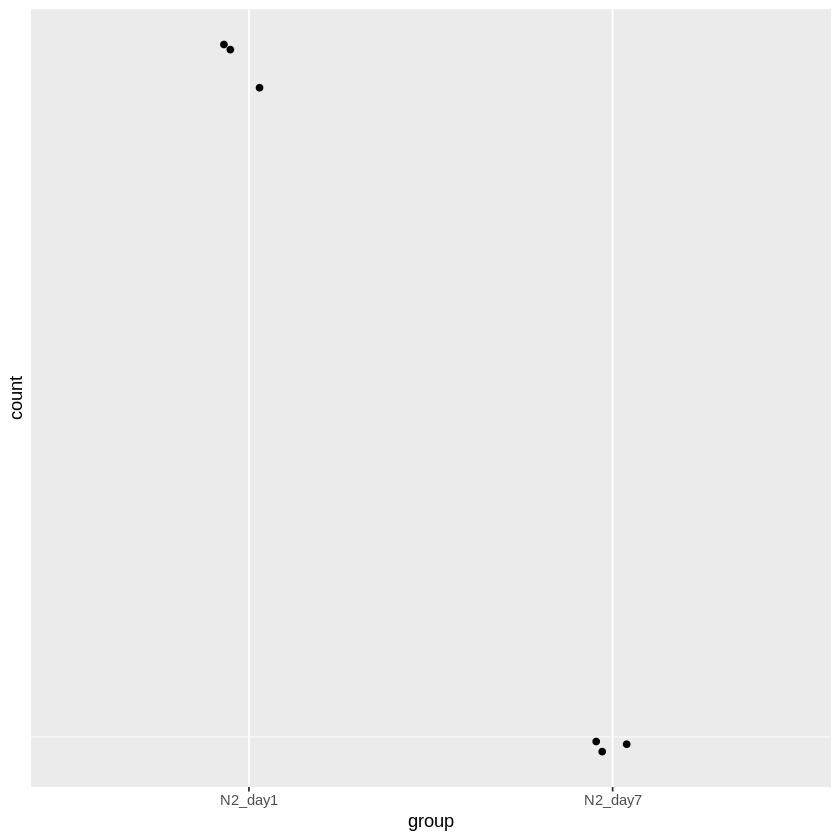

In [ ]:
d <- plotCounts(dds, gene=which.min(res$padj), intgroup="group",
                returnData=TRUE)
library("ggplot2")
ggplot(d, aes(x=group, y=count)) +
  geom_point(position=position_jitter(w=0.1,h=0)) +
  scale_y_log10(breaks=c(25,100,400))

In [ ]:
vsd <- vst(dds, blind=FALSE)

using ntop=500 top features by variance



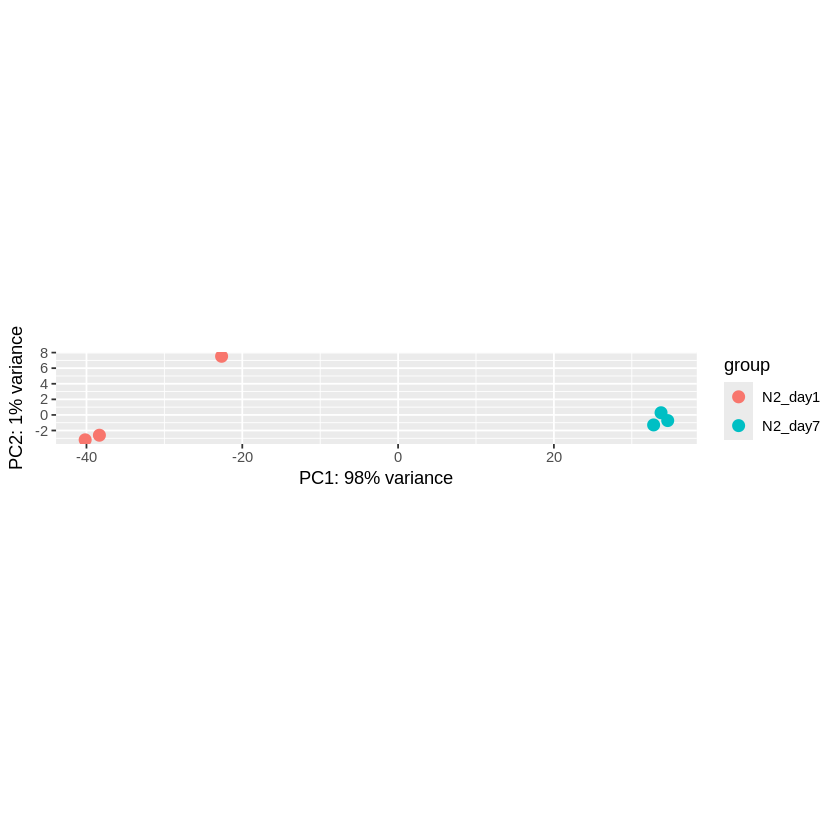

In [ ]:
plotPCA(vsd, intgroup = c("group"))